# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import mythinkstats as mts
import numpy as np
import pandas as pd
print('Ready')

Ready


## Scatter plots

I'll start with the data from the BRFSS again.

In [2]:
brfs = mts.brfss_read_data('ThinkStats2/code/CDBRFS08.ASC.gz')
brfs.head(5)

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


The following function selects a random subset of a `DataFrame`.

In [3]:
# Deleted this function because you can just use the sample() function on the DataFrame object.

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [4]:
brfs_sample = brfs.sample(n=5000)
# heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

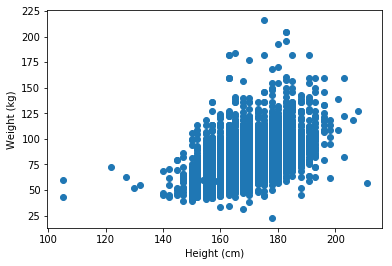

In [5]:
plt.scatter(brfs_sample.htm3, brfs_sample.wtkg2, alpha=1.)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [6]:
# Again a trivial function to just implement in-line.

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

And here's what the jittered data look like.

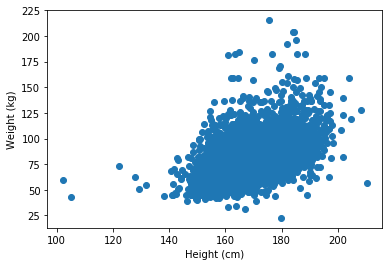

In [7]:
plt.scatter(brfs_sample.htm3 + np.random.normal(0, 1.4, len(brfs_sample)),
            brfs_sample.wtkg2 + np.random.normal(0, 0.5, len(brfs_sample)))
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

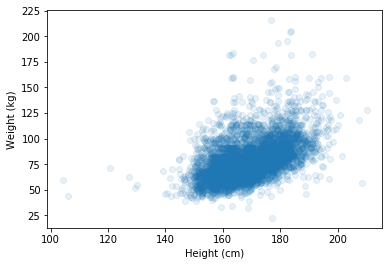

In [8]:
plt.scatter(brfs_sample.htm3 + np.random.normal(0, 1.4, len(brfs_sample)),
            brfs_sample.wtkg2 + np.random.normal(0, 0.5, len(brfs_sample)),
            alpha=0.1)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

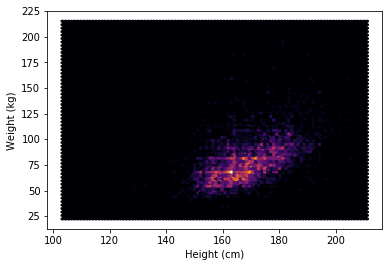

In [9]:
plt.hexbin(brfs_sample.htm3 + np.random.normal(0, 1.4, len(brfs_sample)),
            brfs_sample.wtkg2 + np.random.normal(0, 0.5, len(brfs_sample)), 
            cmap='inferno')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

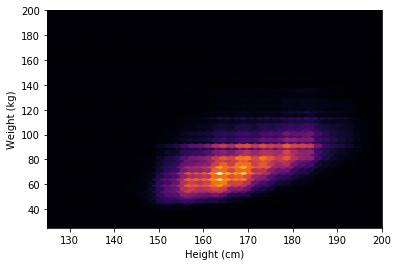

In [10]:
# Solution goes here
plt.hexbin(brfs.htm3 + np.random.normal(0, 1.4, len(brfs)),
           brfs.wtkg2 + np.random.normal(0, 0.5, len(brfs)), 
           cmap='inferno')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.ylim(25, 200)
plt.xlim(125, 200)
plt.show()

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [11]:
brfs_clean = brfs.dropna(subset=['htm3', 'wtkg2'])
len(brfs), len(brfs_clean)

(414509, 395832)

Then I'll divide the dataset into groups by height.

In [12]:
bins = np.arange(135, 210, 5)
indices = np.digitize(brfs_clean.htm3, bins)
groups = brfs_clean.groupby(indices)
groups

Here are the number of respondents in each group:

In [13]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [14]:
mean_heights = [g.htm3.mean() for i, g in groups]
cdfs = [mts.pmf_to_cdf(g.wtkg2.value_counts(normalize=True)) for i, g in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

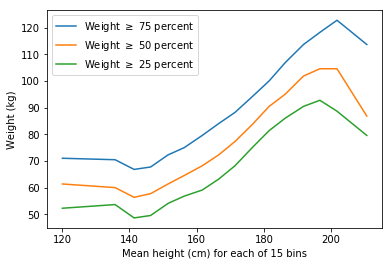

In [15]:
# This plot can show you that, when divided into groups by their weights, 
# all of the groups have a similar height-weight relationship.
for percent in [75, 50, 25]:
    ptiles = [mts.cdf_percentile(cdf, percent) for cdf in cdfs]
    plt.plot(mean_heights, ptiles, label='Weight $\geq$ %d percent' % percent)

plt.ylabel('Weight (kg)')
plt.xlabel('Mean height (cm) for each of %d bins' % len(bins))
plt.legend()
plt.show()

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

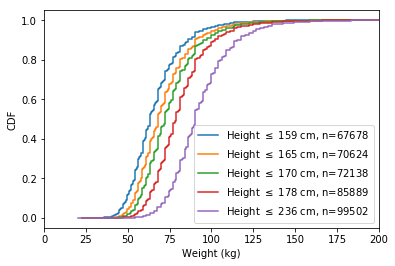

In [16]:
# Compute percentiles from the heights.
height_pmf = brfs_clean.htm3.value_counts(normalize=True)
height_cdf = mts.pmf_to_cdf(height_pmf)
bins = [mts.cdf_percentile(height_cdf, n) for n in [20, 40, 60, 80, 100]]

# Group records by their height percentils.
indices = np.digitize(brfs_clean.htm3, bins)
groups = brfs_clean.groupby(indices)

for (i, group), binval in zip(groups, bins):
    weight_pmf = group.wtkg2.value_counts(normalize=True)
    weight_cdf = mts.pmf_to_cdf(weight_pmf)
    plt.step(weight_cdf.index, weight_cdf.values, 
             label='Height $\leq$ %d cm, n=%d' % (binval, len(group)))
    
plt.xlabel('Weight (kg)')
plt.ylabel('CDF')
plt.xlim(0, 200)
plt.legend()
plt.show()

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [17]:
# Implemented mts.covariance() function.

And here's an example:

In [18]:
mts.covariance(brfs_clean.htm3, brfs_clean.wtkg2)

103.33290857697519

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [19]:
# Implemented mts.pearson_correlation

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [20]:
mts.pearson_correlation(brfs_clean.htm3, brfs_clean.wtkg2)

0.5087351937401179

NumPy provides a function that computes correlations, too:

In [21]:
np.corrcoef(brfs_clean.htm3, brfs_clean.wtkg2)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [22]:
# Implemented mts.spearman_correlation function.

For heights and weights, Spearman's correlation is a little higher:

In [23]:
mts.spearman_correlation(brfs_clean.htm3, brfs_clean.wtkg2)

0.5405846262320477

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [24]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [25]:
SpearmanCorr(brfs_clean.htm3, brfs_clean.wtkg2)

0.5405846262320483

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [26]:
mts.pearson_correlation(brfs_clean.htm3, np.log(brfs_clean.wtkg2))

0.5317269172803073

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [27]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
live = preg[preg.outcome == 1].dropna(subset=['agepreg', 'birthwgt_lb'])
len(live)

9084

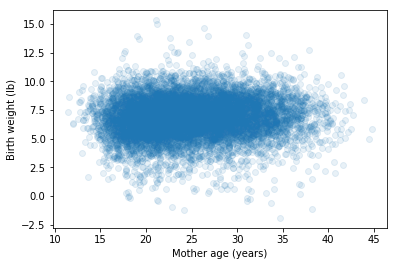

In [28]:
# Solution goes here
plt.scatter(live.agepreg + np.random.normal(0, 1, len(live)),
            live.birthwgt_lb + np.random.normal(0, 1, len(live)),
            alpha=0.1)
plt.xlabel('Mother age (years)')
plt.ylabel('Birth weight (lb)')
plt.show()

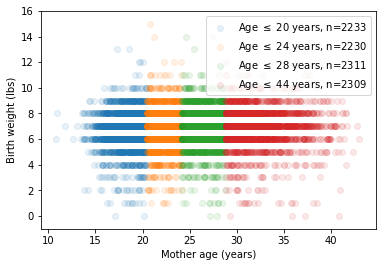

In [29]:
# I wanted to be a little more creative, so this deviates from the exercise.
# The areas of darkness in each age group show that weights are similarly 
# distributed for each age group. But in the end it's just a colored version
# of the scatter plot above :).

# Compute percentiles from the ages.
age_pmf = live.agepreg.value_counts(normalize=True)
age_cdf = mts.pmf_to_cdf(age_pmf)
bins = [mts.cdf_percentile(age_cdf, n) for n in [25, 50, 75, 100]]

# Group records by their age percentiles.
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

for (i, group), binval in zip(groups, bins):
    jitter = np.random.normal(0, 1, len(group))
    plt.scatter(group.agepreg, group.birthwgt_lb, alpha=0.1,
             label='Age $\leq$ %d years, n=%d' % (binval, len(group)))
    
plt.xlabel('Mother age (years)')
plt.ylabel('Birth weight (lbs)')
plt.legend()
plt.show()

In [30]:
# Solution goes here
print('Pearson correlation = %.3lf' % mts.pearson_correlation(live.agepreg, live.birthwgt_lb))
print('Spearma correlation = %.3lf' % mts.spearman_correlation(live.agepreg, live.birthwgt_lb))

Pearson correlation = 0.069
Spearma correlation = 0.095


The fact that spearman correlation is higher than pearson indicates there can be an effect from outliers and that ranking the data lessens this effect.